※ 社内勉強会向け資料です。（2015-11-02）

# 第8章 グラフィカルモデル

確率分布を **確率的グラフィカルモデル** として図で表すことで、

- 確率モデルの構造を視覚的に理解できる
- グラフ構造から、条件付き独立性などの性質が分かる
- グラフ構造が数学表現と対応している

メリットを享受できる。

### 用語定義

- リンク（エッジ、辺）
- ノード（頂点）
- 有向グラフ（ベイジアンネットワーク）
    - DAG （Directed Asynclic Graph: 有向非循環グラフ）
        - ベイジアンネットワークの前提条件として扱われる
- 無向グラフ（マルコフ確率場）
- 因子グラフ（後述）

### 参考

なお、確率的グラフィカルモデルについては、Stanford の下記オンライン授業が詳しい。

- [Probabilistic Graphical Models](https://www.coursera.org/course/pgm) by Daphne Koller

グラフィカルモデルは PRML でもハイライトで、表紙画像にもなっている。

# 8.1 ベイジアンネットワーク
### グラフィカルモデルの例
Daft パッケージを利用して描画してみます。

- 参考: http://daft-pgm.org/examples/badfont/

PGM

- shape: グリッドの大きさ（幅・高さ）
- origin: 左下の座標（x, y）
    - 中心位置でオブジェクトを指定しているので、オフセットを設けるために指定していると思われる
- aspect: ノードの楕円の縦横比

Node
- name
- content: 表示名
- x: x座標
- y: y座標

Edge
- node1
- node2

In [56]:
%matplotlib inline
from matplotlib import rc
import daft
rc("font", family="serif", size=18)
rc("text", usetex=False)

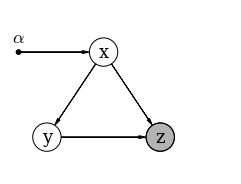

In [57]:
# PGM
pgm = daft.PGM([4, 3], origin=[0.3, 0.3], aspect=1)

# Nodes
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2.5, fixed=True))
pgm.add_node(daft.Node("x", "x", 2.0, 2.5))
pgm.add_node(daft.Node("y", "y", 1.0, 1.0))
pgm.add_node(daft.Node("z", "z", 3.0, 1.0, observed=True))

# Edges
pgm.add_edge("alpha", "x")
pgm.add_edge("x", "y")
pgm.add_edge("y", "z")
pgm.add_edge("x", "z")

# render
pgm.render()

- $\alpha$ は決定的パラメータ
- $z$ は観測値
- x は y の親ノード
- y は x の子ノード

対応するグラフィカルモデル

\begin{equation*}
  p(x, y, z) = p(z|x,y) p(y|x) p(x)
\end{equation*}

同時分布の因子分解（factorization）とグラフィカルモデルは1対1で対応している。

※ 同じ同時確率でも、因子分解の仕方によってグラフィカルモデルの形は異なる

※ すべてのノードの組に対してリンクを持つ場合、全結合であるという


### 分解のための一般公式

\begin{equation*}
  p(x) = \prod_{k=1}^{K} p(x_k|pa_k)
\end{equation*}

有向閉路を持たないグラフ（DAG）は、大きい番号を持つノードから小さい番号を持つノードへのリンクが存在しないように順序付けられる。

※図8.2 の同時分布を因子分解してみよう！！

##  8.1.1 例: 多項式曲線フィッティング

手元に上巻がないんだけど、たぶんこんなやつ。

\begin{equation*}
  t(x, w) = \sum_{i=0}^{N} w_i x^i + \epsilon
\end{equation*}

w の事前分布と、w のもとで t が観測される条件付き確率を使って、t, w の同時分布は下記のように表せる。

\begin{equation*}
  p(t, w) = p(w) \prod_{n=1}^{N} p(t_n | w)
\end{equation*}

※ この具体的な中身を、1.2.6節に戻って、少し復習したい。


これは、いわゆる尤度になるのかな。ノイズの分散 $\sigma^2$ や w の事前分布の精度 $\alpha$ や入力値 $x_n$ も明示的に書くと、

\begin{equation*}
  p(t, w|x, \alpha, \sigma^2) = p(w|\alpha) \prod_{n=1}^{N} p(t_n | w, x_n, \sigma^2)
\end{equation*}

これのグラフィカルモデルが、図8.4 だとか、図8.5 だとかになる。（ごめんなさい、Dart で描く気力がなかったので、[PRMLのページ](http://research.microsoft.com/en-us/um/people/cmbishop/PRML/webfigs.htm#ch8)より引用）

図8.4

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.4.png" width="250px">

図8.5

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.5.png" width="250px">

この四角いのを **プレート** といって、繰り返しを表現することができる。

図8.6

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.6.png" width="250px">

- 観測値は影をつけて表すこともある
- 逆に、観測値でない確率変数を「潜在変数」と言い、確率モデルの中でとても重要な役割を果たす。

グラフィカルモデルのうち、有向なものの作図ルールは、ここまででほぼ網羅されてるんじゃないかな。

## 8.1.2 生成モデル

グラフィカルモデルが書けたら、たいていの場合、ノードの上流から順にデータをサンプリングすることで、確率モデルに従ったデータの組をランダムに生成することができる。これを **伝承サンプリング（ancestral sampling）** という。

→ ルールベースの AI （Agent Based Model）の考え方とも似ている気がする。  

### 物体認識問題の例

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.8.png" width="250px">

観測変数が Image で、それ以外を隠れ変数として生成モデルを組み立てると、位置（position）や向き（orientation）の可能性を積分消去することで、物体（object）の条件付き確率を導出できる。

一方で、前述の多項式回帰モデルは生成モデルとならない。なぜなら、入力データ $x_n$ に対して確率分布が設定されておらず、データを生成できないため。（$x_n$ の確率分布を仮定すれば、生成モデルにできる）

生成モデルは、必ずしも物理的解釈を持つ必要はなく、複雑な同時分布を単純な要素から構成するためだけに導入してもよい（「確率的シミュレーション」じゃないかな）。

生成モデルの考え方は、モデルの形を理解する上で、とっても重要！






----
ここから、代表的な適用例として「離散変数」と「線形ガウスモデル」を扱う。

## 8.1.3 離散変数

各ノードの取りうる状態が有限個で、すべての同時確率を表で表せるようなやつ。

| a | b | c | 確率 |
|--|--|--|--|
| 0 | 0 | 0 | 0.1 |
| 0 | 0 | 1 | 0.1 |
| 0 | 1 | 0 | 0.2 |
| 0 | 1 | 1 | 0.2 |
| 1 | 0 | 0 | 0.3 |
| 1 | 0 | 1 | 0.05 |
| 1 | 1 | 0 | 0.05 |
| 1 | 1 | 1 | 0.0 |

1-of-K 表現さえきちんと理解できていれば、(8.9)式やその次の式は理解できると思う。

1-of-K 表現ってのは、K 個の要素のうち1つだけが1で、それ以外が0のようなベクトル。

### パラメータ数の試算

M個の変数がそれぞれK状態を持つ場合、

- 最も複雑
    - 全結合の場合のパラメータ数: $K^M - 1$
- 最も単純
    - すべての変数が独立な場合のパラメータ数: $M(K-1)$ 
- その間
    - 1つ前の変数だけに依存する場合（例：マルコフ連鎖）: $K-1+(M-1)K(K-1)$

また、パラメータを共有することによっても、パラメータ数を減らすことができる。

図8.11

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.11.png" width="250px">

図8.12

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.12.png" width="250px">

さらに別の方法（パラメータ共有の亜種？）として、パラメトリックなモデルを仮定して、パラメータ数を減らすこともできる。

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.13.png" width="250px">

このようなモデルで $x_n$ がそれぞれ2状態持つとすると、同時確率のパラメータは $2^M -1$ 個必要になる（指数的に増大）。だけど、

\begin{equation*}
  p(y=1|x_1, .. x_M) = \sigma(w^Tx)
\end{equation*}

のようなロジスティックシグモイド関数を仮定すると、M+1個のパラメータで条件付き確率分布を表現できる。

## 8.1.4 線形ガウスモデル

ここでは、有向グラフによって、多変量ガウス分布を表現する方法を学ぶ。

- 最も単純な例: 対角共分散（非対角要素が0、すなわち要素間が独立）
- 最も複雑な例: 一般の多変量ガウス分布
- その間: 部分的に要素間に制約あり

確率的主成分分析や、確率的因子分析、線形動的システム（状態空間モデルかも）で、本節での手法が広く利用されている。

### 多変量ガウス分布

有向非循環グラフを想定して、確率分布を式で表すと下記のような感じ。

\begin{equation*}
  p(x_i|pa_i) = N(x_i | \sum_{j \in pa_i}^{}w_{ij}x_j + b_j, v_i)
\end{equation*}

上流から順に値を決めていった場合に、下流のガウス分布の平均値が、上流の変数の値で決まる。各変数のガウス分布の分散は一定。

対数尤度を求めてみようぜ。

\begin{equation*}
  \ln p(x) = \sum_{i=1}^D \ln p(x_i|pa_i)  \\
    = - \sum_{i=1}^D \frac{1}{2v_i}(x_i - \sum_{j \in pa_i}^{}w_{ij}x_{j}-b_i)^2 + const.
\end{equation*}

結局、上記の有向非循環グラフは、多変量ガウス分布となることが分かる。

この同時分布の平均や共分散は、番号の小さいノードから順に再帰計算をすることによって求められる。

#### パラメータ数の見積もり

- すべての変数が独立な場合
    - 各変数ごとに平均と分散を持つので、2D個
- 全結合の場合
    - 共分散行列が全要素に値を持つので D(D+1)/2 個

その間の場合は、一部パラメータを省略できる。

図8.14

<img src="http://research.microsoft.com/en-us/um/people/cmbishop/PRML/prmlfigs-png/Figure8.14.png" width="250px">

### ガウス分布の平均 $\mu$ の共役事前分布をガウス分布とした場合


ガウス分布に従う $x$ の平均を $\mu$、 $\mu$ の平均を $\mu'$（がうすぶｎ）、$\mu'$ もガウス分布に従うとして平均を $\alpha$ とすると、以下の様な階層ベイズモデル（いくらでも多段にできる）で表せる。（ここではいったん、分散は無視している）


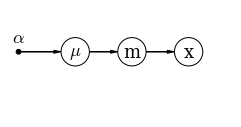

In [63]:
# PGM
pgm = daft.PGM([4, 2], origin=[0.3, 0.3], aspect=1)

# Nodes
pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 1.5, fixed=True))
pgm.add_node(daft.Node("mu", r"$\mu$", 1.5, 1.5))
pgm.add_node(daft.Node("m", "m", 2.5, 1.5))
pgm.add_node(daft.Node("x", "x", 3.5, 1.5))

# Edges
pgm.add_edge("alpha", "mu")
pgm.add_edge("mu", "m")
pgm.add_edge("m", "x")

# render
pgm.render()